In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.mllib.linalg import DenseVector

In [2]:
sqlContext = SQLContext(sc)

In [3]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/MW-timestamp-NEW.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [4]:
dataDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491035,0,1587256
air_pressure,1587257,916.8301266904964,3.051593126680745,905.0,929.5
air_temp,1587257,61.85144042834878,11.833623786835721,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970203971,0.0,359.0
avg_wind_speed,1586824,2.774272067979844,2.0607577935630355,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.3672342806429,0.0,359.0
max_wind_speed,1586824,3.3998134008569685,2.423167433617133,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.46274620077615,0.0,359.0
min_wind_speed,1586824,2.1331304542917913,1.745345084932679,0.0,32.0


In [5]:
dataDF.count()

1587257

In [22]:
#Down sample to take every 10th value
filtered = dataDF.filter((dataDF.rowID % 10) == 0)

In [23]:
filtered.count()

158726

In [8]:
#SELECT required columns and drop rows with NULL

cols = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

workingDF = filtered.select(cols).na.drop()

In [9]:
workingDF.take(2)

[Row(air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(air_pressure=912.3, air_temp=62.24, avg_wind_direction=144.0, avg_wind_speed=1.2, max_wind_direction=167.0, max_wind_speed=1.8, relative_humidity=38.5)]

In [10]:
#CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [11]:
workingDF.columns

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

In [12]:
#ASSEMBLE all the features.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [13]:
#SCALE the dataset.

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)

# Fit the StandardScaler
scalerModel = scaler.fit(assembled)

# Normalize each feature
scaledData = scalerModel.transform(assembled)

In [14]:
#Perform Clustering.

from pyspark.ml.clustering import KMeans
howManyClusters = 12

# Trains a k-means model.
kmeans      = KMeans(k=howManyClusters, seed = 1)
model       = kmeans.fit(scaledData)
transformed = model.transform(scaledData)
featuresAndPrediction     = transformed.select("features", "prediction")

In [15]:
#How many members per clusters
import pyspark.sql.functions as func

featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|            10573|
|         1|            13422|
|         2|            14833|
|         3|            18638|
|         4|             4633|
|         5|            15793|
|         6|            11535|
|         7|            18995|
|         8|            25630|
|         9|            11968|
|        10|             2249|
|        11|            10411|
+----------+-----------------+



In [16]:
# Print cluster centers.

print(cols)
#allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]

print("\nCLUSTER CENTERS: \n")
for center in model.clusterCenters():
    print(center)

['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed', 'relative_humidity']

CLUSTER CENTERS: 

[ 1.3043177  -0.24030114 -1.15387809  1.73371066 -1.04692201  1.83870394
 -1.12200481]
[ 0.15751205 -0.74345552 -1.21984653 -0.54988543 -1.07080566 -0.56542011
  0.76523163]
[-0.84408569 -1.18714659  0.35906729  0.37705119  0.48557782  0.3622125
  1.3504302 ]
[-0.22585128  0.64177068  0.40939938  0.70750203  0.51838698  0.64736436
 -0.14786832]
[ 0.1316567   0.84599709  1.89333604 -0.62811164 -1.54748661 -0.55455231
 -0.75396777]
[ 0.20473291 -0.9831286   0.6422715  -0.54885846  0.8595796  -0.53230441
  1.16837617]
[ 0.97090599  0.23516064  0.21466114 -0.49957322  0.40200752 -0.5031493
 -0.80817985]
[-0.61793223  0.61682555  0.13398891 -0.6199921   0.30534198 -0.63439095
 -0.19456452]
[ 0.28451552  0.6349466  -1.30641379 -0.47416785 -1.167003   -0.48287242
 -0.79755924]
[ 0.13321964  0.86068327  1.37398803 -0.63856793  1.63826957 -0.58949

In [17]:
# This function evaluates WSSE  -  Within Set Sum of Squared Errors.
from numpy import array
from math import sqrt

def wssse(featuresAndPrediction, model):
    # Get centers of all clusters
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    # Map to a collection of arrays
    arrayCollection   = featuresAndPrediction.rdd.map(array)
    # Given a point, return its distance from Center of the Class assigned

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        return sqrt(sum([x*x for x in (point - center)]))
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [18]:
# print(wssse(featuresAndPrediction, model))

In [25]:
scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [26]:
#ELBOW method

wssseList = []

for howManyClusters in range(2,31):
    #train kmeans
    print('Training for k = ',  howManyClusters)
    kmeans      = KMeans(k=howManyClusters, seed = 1)
    model       = kmeans.fit(scaledData)
    transformed = model.transform(scaledData)
    featuresAndPrediction     = transformed.select("features", "prediction")
    
    #get wsse
    print("Calculating WSSSE")
    W = wssse(featuresAndPrediction, model)
    print(W)
    
    #store wsse so we can plot it
    wssseList.append(W)

('Training for k = ', 2)
Calculating WSSSE
348521.951115
('Training for k = ', 3)
Calculating WSSSE
307527.01438
('Training for k = ', 4)
Calculating WSSSE
283783.638931
('Training for k = ', 5)
Calculating WSSSE
264162.225034
('Training for k = ', 6)
Calculating WSSSE
255377.662402
('Training for k = ', 7)
Calculating WSSSE
248653.954362
('Training for k = ', 8)
Calculating WSSSE
235612.104453
('Training for k = ', 9)
Calculating WSSSE
229414.809525
('Training for k = ', 10)
Calculating WSSSE
219657.595294
('Training for k = ', 11)
Calculating WSSSE
213931.099861
('Training for k = ', 12)
Calculating WSSSE
213756.874047
('Training for k = ', 13)
Calculating WSSSE
207619.27707
('Training for k = ', 14)
Calculating WSSSE
206548.66922
('Training for k = ', 15)
Calculating WSSSE
200182.270542
('Training for k = ', 16)
Calculating WSSSE
197541.502133
('Training for k = ', 17)
Calculating WSSSE
192786.437982
('Training for k = ', 18)
Calculating WSSSE
193767.910009
('Training for k = ', 19)

## Plots

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

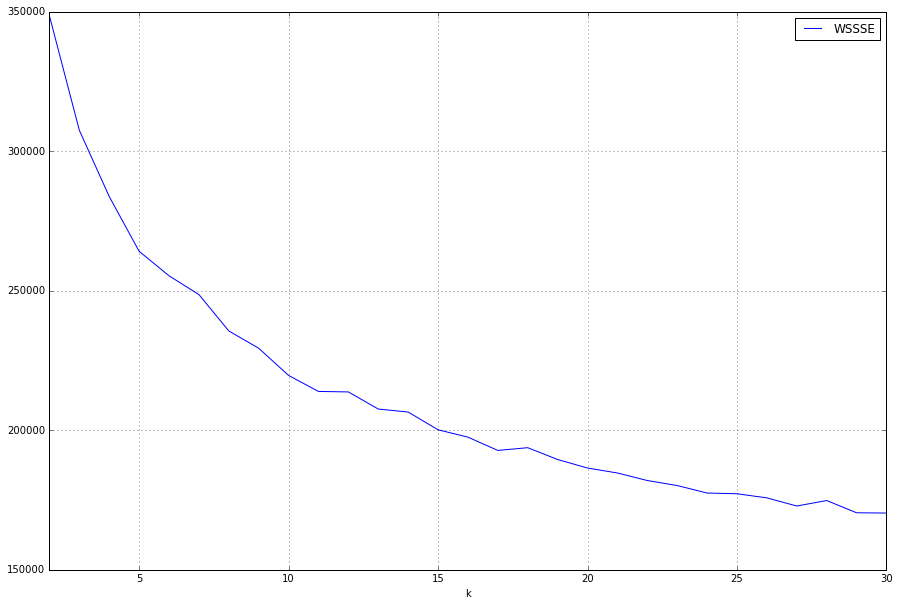

In [63]:
wssseDF = pd.DataFrame({'WSSSE' : wssseList, 'k' : range(2,31) })
wssseDF.plot(y='WSSSE', x='k', figsize=(15,10), grid=True)

In [42]:
kmeans      = KMeans(k=12, seed = 1)
model       = kmeans.fit(scaledData)
transformed = model.transform(scaledData)
featuresAndPrediction     = transformed.select("features", "prediction")
W = wssse(featuresAndPrediction, model)
print(W)

213756.874047


In [43]:
from pandas.tools.plotting import parallel_coordinates
import numpy as np

In [44]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [45]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)

In [48]:
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,1.304318,-0.240301,-1.153878,1.733711,-1.046922,1.838704,-1.122005,0.0
1,0.157512,-0.743456,-1.219847,-0.549885,-1.070806,-0.565420,0.765232,1.0
2,-0.844086,-1.187147,0.359067,0.377051,0.485578,0.362212,1.350430,2.0
3,-0.225851,0.641771,0.409399,0.707502,0.518387,0.647364,-0.147868,3.0
4,0.131657,0.845997,1.893336,-0.628112,-1.547487,-0.554552,-0.753968,4.0
5,0.204733,-0.983129,0.642272,-0.548858,0.859580,-0.532304,1.168376,5.0
6,0.970906,0.235161,0.214661,-0.499573,0.402008,-0.503149,-0.808180,6.0
7,-0.617932,0.616826,0.133989,-0.619992,0.305342,-0.634391,-0.194565,7.0
8,0.284516,0.634947,-1.306414,-0.474168,-1.167003,-0.482872,-0.797559,8.0
9,0.133220,0.860683,1.373988,-0.638568,1.638270,-0.589493,-0.714741,9.0


## Dry Days

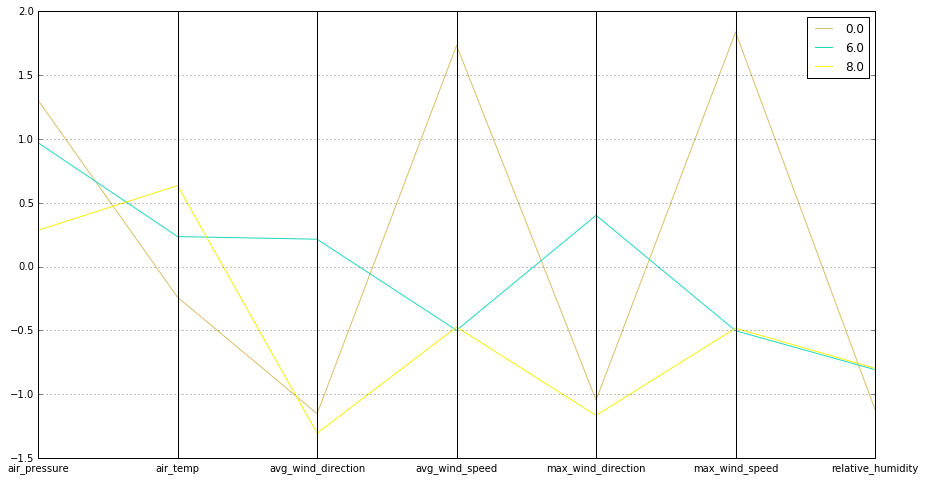

In [62]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8))
parallel_coordinates(P[P['relative_humidity']< -0.76], 'prediction')

## Warm Days

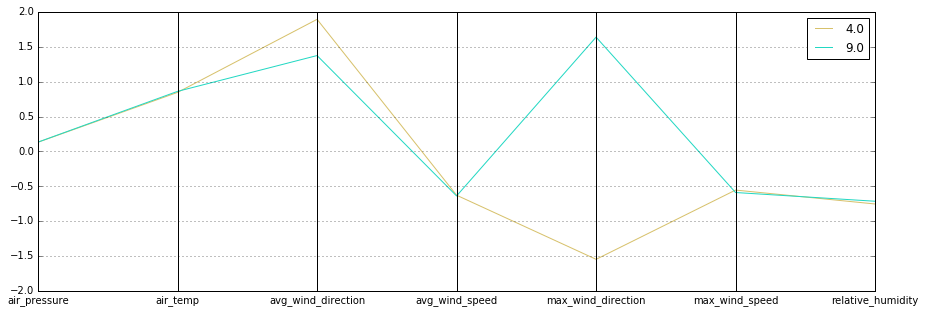

In [59]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,5))
parallel_coordinates(P[P['air_temp']> 0.8], 'prediction')

## Cool and Rainy Days

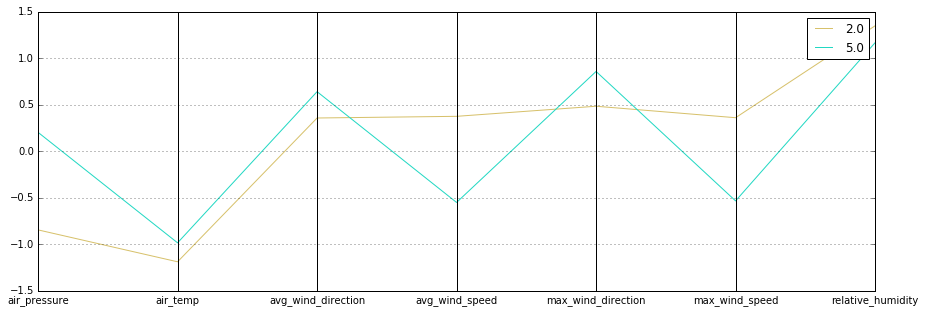

In [57]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,5))
parallel_coordinates(P[(P['relative_humidity']>1.0) & (P['air_temp']< 0.5)], 'prediction')